In [1]:
from core.DataLoader import *
from core.models.MLP import * 
from core.models.GAM import *
from core.models.SVM import *
# from core.models.EBM import *

from core.models.RandomForest import *
from core.Visualizer import *
from core.models.Classifier import *
from core.models.XGB import *

In [2]:
# model_accs = {
#     'MLP': [],
#     'RF(5)': [],
#     'RF(10)': [],
#     'RF(U)': [],
#     'DT(5)': [],
#     'DT(10)': [],
#     'DT(U)': [],
#     'LR': [],
#     'SVM': [],
#     'XGB': []
# }
# present_idxs = [0, 1, 2, 3, 4, 5, 8 ,12, 21, 22, 23, 24]

In [3]:
weighted_clf_model_list ={
    "MLP": MLPClassifier,
    "DT": m_DecisionTreeClassifier,
    "RF": m_RandomForestClassifier,
    "LR": m_LogisticRegression,
    "SVM": SVMClassifier,
    "XGB": XGBOOSTClassifier
}
# weighted_clf_model_name_list = ['MLP', 'RF(5)', 'RF(U)', 'DT(5)', 'DT(U)', 'LR', 'SVM', 'XGB']
# weighted_clf_model_name_list = ['MLP', 'RF(U)', 'DT(U)']
# weighted_clf_model_name_list = ['DT(5)', 'RF(5)', 'MLP']
# weighted_clf_model_name_list = ['DT(5)', 'RF(5)']
weighted_clf_model_name_list = ['MLP']


In [4]:
engine = 'postgres'
# if engine == 'mssql':
#     baseline = mssql_accs
# else:
#     baseline = postgres_accs
dl = DataLoader(engine)
# one_file_dss, one_file_names = dl.get_one_file_ds(return_type='ds and names', datasets=['ssb', 'tpch', 'imdb'])
one_file_dss, one_file_names = dl.get_one_file_ds(return_type='ds and names', datasets=['ssb', 'tpch', 'tpch_10', 'tpch_100', 'imdb'])


In [5]:
all_features = dl.all_features
classification_target = dl.classification_target
all_features =['left_cardinality',
 'base_cardinality',
#  'sel_of_pred_on_indexed_attr',
#  'sel_of_pred_on_non_indexed_attr',
 'min_sel_on_attr',
 'sel_of_join_pred',
 'left_ordered',
 'base_ordered',
 'left_indexed',
 'base_indexed',
 'result_size',
 'predicate_op_num_on_indexed_attr',
 'predicate_op_num_on_non_indexed_attr']
# key_feature_set = 0
# features = key_features[key_feature_set]
# print("Using features: ", features)

In [6]:
# feature_groups = [
#     ['left_cardinality', 'base_cardinality', 'result_size'],
#     ['sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr', 'sel_of_pred_on_indexed_attr_and_join_pred',
#      'sel_of_pred_on_non_indexed_attr_and_join_pred', 'sel_of_pred_on_indexed_attr_and_non_indexed_attr',
#      'total_sel_on_base_table', 'predicate_op_num_on_indexed_attr', 'predicate_op_num_on_non_indexed_attr'],
#     [ 'left_ordered', 'base_ordered', 'left_indexed', 'base_indexed']    
# ]
# ds = one_file_dss[0][all_features]

# Base accuracy with all features

In [7]:
present_idxs = list(range(len(one_file_dss)))    
features = all_features.copy()
    
full_model_accs = {
    'MLP': [],
    'RF(5)': [],
    'RF(U)': [],
    'DT(5)': [],
    'DT(U)': [],
    'LR': [],
    'SVM': [],
    'XGB': []
}

for i in present_idxs:  # range(len(one_file_dss)):
#     i = 0
    print(f"Processing: {i}")
    # ds = one_file_dss[i][one_file_dss[i]['predicate_op_num_on_non_indexed_attr'] == 0]
    ds = one_file_dss[i]
    ds_name = one_file_names[i]

    # =========================
    X = ds[features]
    y = ds['optimal_decision']
    X_costs = ds[dl.regression_targets]

    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
    X_train_costs, _, _, _, = train_test_split(X_costs, y, train_size=0.8, random_state=1)
    X_train, X_test, y_train, y_test = \
        X_train.to_numpy(),X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

    X_train_weights = calculate_importance_from_costs(X_train_costs.to_numpy())

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)

    # scaler = preprocessing.StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)

    X_train_weights = preprocessing.MinMaxScaler().fit_transform(X_train_weights.reshape(-1,1)).flatten()
    # =========================

    accs = []
    for idx, model_name in enumerate(weighted_clf_model_name_list):
        model = weighted_clf_model_list[model_name.split('(')[0]]        
        if 'DT' in model_name or 'RF' in model_name:
            max_depth = model_name.split('(')[-1].split(')')[0]
            if max_depth.lower() == 'u':
                max_depth = None
            else:
                max_depth = int(max_depth)
            clf = model().fit(X_train, y_train, sample_weight=None, max_depth=max_depth)
        else:
            clf = model().fit(X_train, y_train, sample_weight=None, max_iter=20)

        print(f"Accuray of {model}: {clf.score(X_test, y_test)}")
#         if len(features) == 2:
#             plot_2d_decision_boundaries(clf, scaler.inverse_transform(X_train), X_train_costs, y_train, title=f'{model} on {one_file_names[i]}')

        full_model_accs[model_name].append(clf.score(X_test, y_test))
#         accs.append(clf.score(X_test, y_test))

  0%|          | 0/20 [00:00<?, ?it/s]

Processing: 0
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 1
set features: 11


100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 2


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8625
Processing: 3
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8125
Processing: 4
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 5
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 6
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 11


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 9
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.86
Processing: 10
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 11
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 12
set features: 11


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 13


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 11


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 17


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 18
set features: 11


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 20
set features: 11


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 21


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 22
set features: 11


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 24
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.87
Processing: 25
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 26
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 27
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 28
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 29
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 30
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 31
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
Processing: 32
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9425
Processing: 33
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 35
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 36
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 37
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 39
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 40
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.94
Processing: 41
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 42
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 43
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 44
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 45
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 46
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 47
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 48
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 11


100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 51
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 52
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8425
Processing: 54
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.86
Processing: 55
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9575
Processing: 56
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 57
set features: 11


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 58


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 59
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 60
set features: 11


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.935
Processing: 61
set features: 11


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 62


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 11


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125


# Remove feature acc

In [8]:
present_idxs = list(range(len(one_file_dss)))
removed_acc = {}

for feat_idx, feat_in_group in enumerate(all_features):
    
    features = all_features.copy()
    
    features.remove(feat_in_group)
    
    print(f"remove feature {feat_in_group}: after remove length: %d"%len(features))
    
    model_accs = {
        'MLP': [],
        'RF(5)': [],
        'RF(U)': [],
        'DT(5)': [],
        'DT(U)': [],
        'LR': [],
        'SVM': [],
        'XGB': []
    }
    
    for i in present_idxs:  # range(len(one_file_dss)):
    #     i = 0
        print(f"Processing: {i}")
        # ds = one_file_dss[i][one_file_dss[i]['predicate_op_num_on_non_indexed_attr'] == 0]
        ds = one_file_dss[i]
        ds_name = one_file_names[i]

        # =========================
        X = ds[features]
        y = ds['optimal_decision']
        X_costs = ds[dl.regression_targets]

        from sklearn.model_selection import train_test_split
        from sklearn import preprocessing

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
        X_train_costs, _, _, _, = train_test_split(X_costs, y, train_size=0.8, random_state=1)
        X_train, X_test, y_train, y_test = \
            X_train.to_numpy(),X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

        X_train_weights = calculate_importance_from_costs(X_train_costs.to_numpy())

        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)

        # scaler = preprocessing.StandardScaler().fit(X_test)
        X_test = scaler.transform(X_test)

        X_train_weights = preprocessing.MinMaxScaler().fit_transform(X_train_weights.reshape(-1,1)).flatten()
        # =========================

        accs = []
        for idx, model_name in enumerate(weighted_clf_model_name_list):
            model = weighted_clf_model_list[model_name.split('(')[0]]        
            if 'DT' in model_name or 'RF' in model_name:
                max_depth = model_name.split('(')[-1].split(')')[0]
                if max_depth.lower() == 'u':
                    max_depth = None
                else:
                    max_depth = int(max_depth)
                clf = model().fit(X_train, y_train, sample_weight=None, max_depth=max_depth)
            else:
                clf = model().fit(X_train, y_train, sample_weight=None, max_iter=20)

            print(f"Accuray of {model}: {clf.score(X_test, y_test)}")
    #         if len(features) == 2:
    #             plot_2d_decision_boundaries(clf, scaler.inverse_transform(X_train), X_train_costs, y_train, title=f'{model} on {one_file_names[i]}')

            model_accs[model_name].append(clf.score(X_test, y_test))
    #         accs.append(clf.score(X_test, y_test))
    
    removed_acc["%d" % feat_idx] = model_accs

  0%|          | 0/20 [00:00<?, ?it/s]

remove feature left_cardinality: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8625
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.82
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8725
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8725
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 17
set features: 10


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.88
Processing: 18


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8075
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.875
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9625
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9675
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8725
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9425
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9625
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 45
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 47
set features: 10


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 48


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 51
set features: 10


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 52


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.835
Processing: 54
set features: 10


100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8275
Processing: 55


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.955
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 58
set features: 10


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 59
set features: 10


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 60


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
remove feature base_cardinality: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.865
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.815
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.865
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.875
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 21
set features: 10


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 22
set features: 10

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8425
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8575
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9675
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 32
set features: 10


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 33


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 39
set features: 10


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.935
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 42
set features: 10


100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 43


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 45
set features: 10


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 46


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8575
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8675
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9525
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 57
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  8.00it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 58
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.94
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.935
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
remove feature min_sel_on_attr: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.87
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9525
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8625
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.815
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.87
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8825
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8825
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 20
set features: 10


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 21


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.965
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.83
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.855
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.87
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8825
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 45
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8875
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.81
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.85
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 56
set features: 10


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 58
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
remove feature sel_of_join_pred: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9625
Processing: 2
set features: 10


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8575
Processing: 3


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8275
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8525
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.88
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9675
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.88
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 36
set features: 10


  5%|▌         | 1/20 [00:00<00:03,  6.21it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8825
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.94
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 45
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8325
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8625
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.96
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 58
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9575
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
remove feature left_ordered: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.865
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8125
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9625
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  6.46it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8675
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 13
set features: 10


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 24


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8675
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8825
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.95
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.94
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 35
set features: 10


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 36


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9475
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 44
set features: 10


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 45


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.875
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8375
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8625
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.965
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9425
Processing: 58
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9375
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.94
remove feature base_ordered: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.815
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8475
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.86
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 35
set features: 10


  5%|▌         | 1/20 [00:00<00:03,  6.25it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9475
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 45
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.835
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.86
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9525
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 58
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.935
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.945
remove feature left_indexed: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8775
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.815
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.865
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.865
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.865
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 30
set features: 10


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 31


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8725
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.945
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 45
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8325
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8575
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9475
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 58
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  7.55it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.935
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9375
remove feature base_indexed: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.82
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.855
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.88
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9375
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 21
set features: 10


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 22
set features: 10

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.86
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8775
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 33
set features: 10


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.835
Processing: 39
set features: 10


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 40


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.945
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8875
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 44
set features: 10


100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 45


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 46


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8325
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8575
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9475
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
Processing: 58
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9375
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.93
remove feature result_size: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.885
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8575
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.82
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.975
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8325
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8775
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9625
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8475
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9475
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8875
Processing: 42
set features: 10


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 43


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 45
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 52
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  7.72it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8225
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8525
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 57
set features: 10


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 58
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  7.46it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.94
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9425
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
remove feature predicate_op_num_on_indexed_attr: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8425
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.7775
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.855
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 16
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9675
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 24
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.84
Processing: 25
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8725
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.91
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.97
Processing: 29
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 31
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  7.67it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 32
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8225
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.945
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 45
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9125
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9975
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.845
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8675
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.96
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9175
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8875
Processing: 58
set features: 10


  5%|▌         | 1/20 [00:00<00:01,  9.73it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9275
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.935
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225
Processing: 62
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.925
remove feature predicate_op_num_on_non_indexed_attr: after remove length: 10
Processing: 0
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8825
Processing: 1
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 2
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8625
Processing: 3
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.795
Processing: 4
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 5
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 6
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 7
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 8
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 9
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.835
Processing: 10
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8675
Processing: 11
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.895
Processing: 12
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 13
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 14
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  6.57it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 15
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9725
Processing: 16
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  7.00it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8725
Processing: 17
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 18
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 19
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 20
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9775
Processing: 21
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 22
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 23
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.875
Processing: 24
set features: 10


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.85
Processing: 25


  0%|          | 0/20 [00:00<?, ?it/s]

set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8825
Processing: 26
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 27
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.89
Processing: 28
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.985
Processing: 29
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  7.24it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 30
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 31
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9025
Processing: 32
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  6.51it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 33
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 34
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.995
Processing: 35
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.99
Processing: 36
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 37
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 38
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8975
Processing: 39
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.915
Processing: 40
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.945
Processing: 41
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 42
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 43
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9875
Processing: 44
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 45
set features: 10


  5%|▌         | 1/20 [00:00<00:02,  7.42it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9925
Processing: 46
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8925
Processing: 47
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9
Processing: 48
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 49
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 50
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.98
Processing: 51
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9825
Processing: 52
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 1.0
Processing: 53
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.84
Processing: 54
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.8225
Processing: 55
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.96
Processing: 56
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.905
Processing: 57
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 58
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 59
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9325
Processing: 60
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.92
Processing: 61
set features: 10


  0%|          | 0/20 [00:00<?, ?it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9075
Processing: 62
set features: 10


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]

Accuray of <class 'core.models.MLP.MLPClassifier'>: 0.9225


In [ ]:
# removed_acc.keys()

In [ ]:
# import json
# with open('acc_drop_postgres.json', 'w') as fp:
#     json.dump(removed_acc, fp)

In [ ]:
# import json 
  
# # Opening JSON file 
# with open('removed_acc_postgres.json', 'r') as json_file: 
#     removed_acc_MLP = json.load(json_file) 

# Feature rank per binary join

In [9]:
top_feature_chosen = {}
for model_name in weighted_clf_model_name_list:
    model_features = []
    for i in range(len(full_model_accs[model_name])):
        full_acc = full_model_accs[model_name][i]
        ablation_accs = []
        for feat_idx in range(len(all_features)):
            ablation_accs.append(removed_acc["%d" % feat_idx][model_name][i])
        ablation_accs = np.array(ablation_accs)
        if sum(ablation_accs) == ablation_accs[0] * len(ablation_accs):
            ablation_accs[range(len(ablation_accs))] = 0
        else:  
            sort_idx = np.argsort(ablation_accs)
            ablation_accs[sort_idx[0:2]] = 1
            ablation_accs[sort_idx[2:]] = 0
        model_features.append(ablation_accs)
#         print(ablation_accs)
    top_feature_chosen[model_name] = model_features

In [10]:
# starting_n = 8 + 15

for model_name in weighted_clf_model_name_list:
    print(f"For model {model_name}")
    sum_feat = np.zeros(len(all_features))
    for idx, ds_name in zip(range(len(one_file_dss)), one_file_names):
        print(f"{ds_name}: ", top_feature_chosen[model_name][idx])
        sum_feat += top_feature_chosen[model_name][idx]
    print(f"Summary for {model_name}: ", sum_feat)
    print()

For model MLP
ssb part/postgres_lineorder_part_optimal.csv:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
ssb customer/postgres_lineorder_customer_optimal.csv:  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
ssb ddate/postgres_lineorder_ddate_optimal.csv:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
ssb supplier/postgres_lineorder_supplier_optimal.csv:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
ssb lineorder/postgres_part_lineorder_optimal.csv:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
ssb lineorder/postgres_customer_lineorder_optimal.csv:  [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
ssb lineorder/postgres_ddate_lineorder_optimal.csv:  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ssb lineorder/postgres_supplier_lineorder_optimal.csv:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
tpch customer/postgres_orders_customer_optimal.csv:  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
tpch orders/postgres_customer_orders_optimal.csv:  [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
tpch orders/postgres_lineitem_orders_optimal.csv:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
tpch part/postgres_line

# Average the model performance drop

## DT drop

In [15]:
# dt_drop = []

# for idx, feat_t in enumerate(all_features):
#     acc = removed_acc["%d" % idx]['DT(5)']
#     drops = []
#     for i in range(len(present_idxs)):
#         drops.append(acc[i] - DT_5_pg_acc[i])
#     dt_drop.append(-np.average(drops))
#     print(f"Avg drop for {feat_t}: {np.average(drops)}")
    

Avg drop for left_cardinality: -0.011874999999999978
Avg drop for base_cardinality: -0.0012500000000000011
Avg drop for sel_of_pred_on_indexed_attr: -0.09479166666666665
Avg drop for sel_of_pred_on_non_indexed_attr: -0.005208333333333333
Avg drop for sel_of_join_pred: -0.001666666666666668
Avg drop for left_ordered: -0.000833333333333334
Avg drop for base_ordered: 0.0
Avg drop for left_indexed: -0.000416666666666667
Avg drop for base_indexed: -0.000416666666666667
Avg drop for result_size: -0.00416666666666667
Avg drop for predicate_op_num_on_indexed_attr: -0.0025000000000000113
Avg drop for predicate_op_num_on_non_indexed_attr: -0.000416666666666667


In [16]:
# rf_drop = []

# for idx, feat_t in enumerate(all_features):
#     acc = removed_acc["%d" % idx]['RF(5)']
#     drops = []
#     for i in range(len(present_idxs)):
#         drops.append(acc[i] - RF_5_pg_acc[i])
#     rf_drop.append(-np.average(drops))
#     print(f"Avg drop for {feat_t}: {np.average(drops)}")

Avg drop for left_cardinality: -0.021041666666666653
Avg drop for base_cardinality: 0.012500000000000011
Avg drop for sel_of_pred_on_indexed_attr: -0.10104166666666663
Avg drop for sel_of_pred_on_non_indexed_attr: -0.005416666666666653
Avg drop for sel_of_join_pred: 0.0029166666666666694
Avg drop for left_ordered: 0.0020833333333333446
Avg drop for base_ordered: 0.007500000000000016
Avg drop for left_indexed: 0.006666666666666682
Avg drop for base_indexed: 0.003541666666666665
Avg drop for result_size: 0.00416666666666667
Avg drop for predicate_op_num_on_indexed_attr: 0.011666666666666678
Avg drop for predicate_op_num_on_non_indexed_attr: 0.011041666666666672


In [13]:
mlp_drop = []

for idx, feat_t in enumerate(all_features):
    acc = removed_acc["%d" % idx]['MLP']
    drops = []
    for i in range(len(present_idxs)):
        drops.append(acc[i] - postgres_accs[0][i])
    mlp_drop.append(-np.average(drops))
    print(f"Avg drop for {feat_t}: {np.average(drops)}")

Avg drop for ['left_cardinality', 'base_cardinality', 'result_size']: -0.12520833333333334
Avg drop for ['sel_of_pred_on_indexed_attr', 'sel_of_pred_on_non_indexed_attr', 'sel_of_pred_on_indexed_attr_and_join_pred', 'sel_of_pred_on_non_indexed_attr_and_join_pred', 'sel_of_pred_on_indexed_attr_and_non_indexed_attr', 'total_sel_on_base_table', 'predicate_op_num_on_indexed_attr', 'predicate_op_num_on_non_indexed_attr']: -0.09833333333333333
Avg drop for ['left_ordered', 'base_ordered', 'left_indexed', 'base_indexed']: 0.0018750000000000155


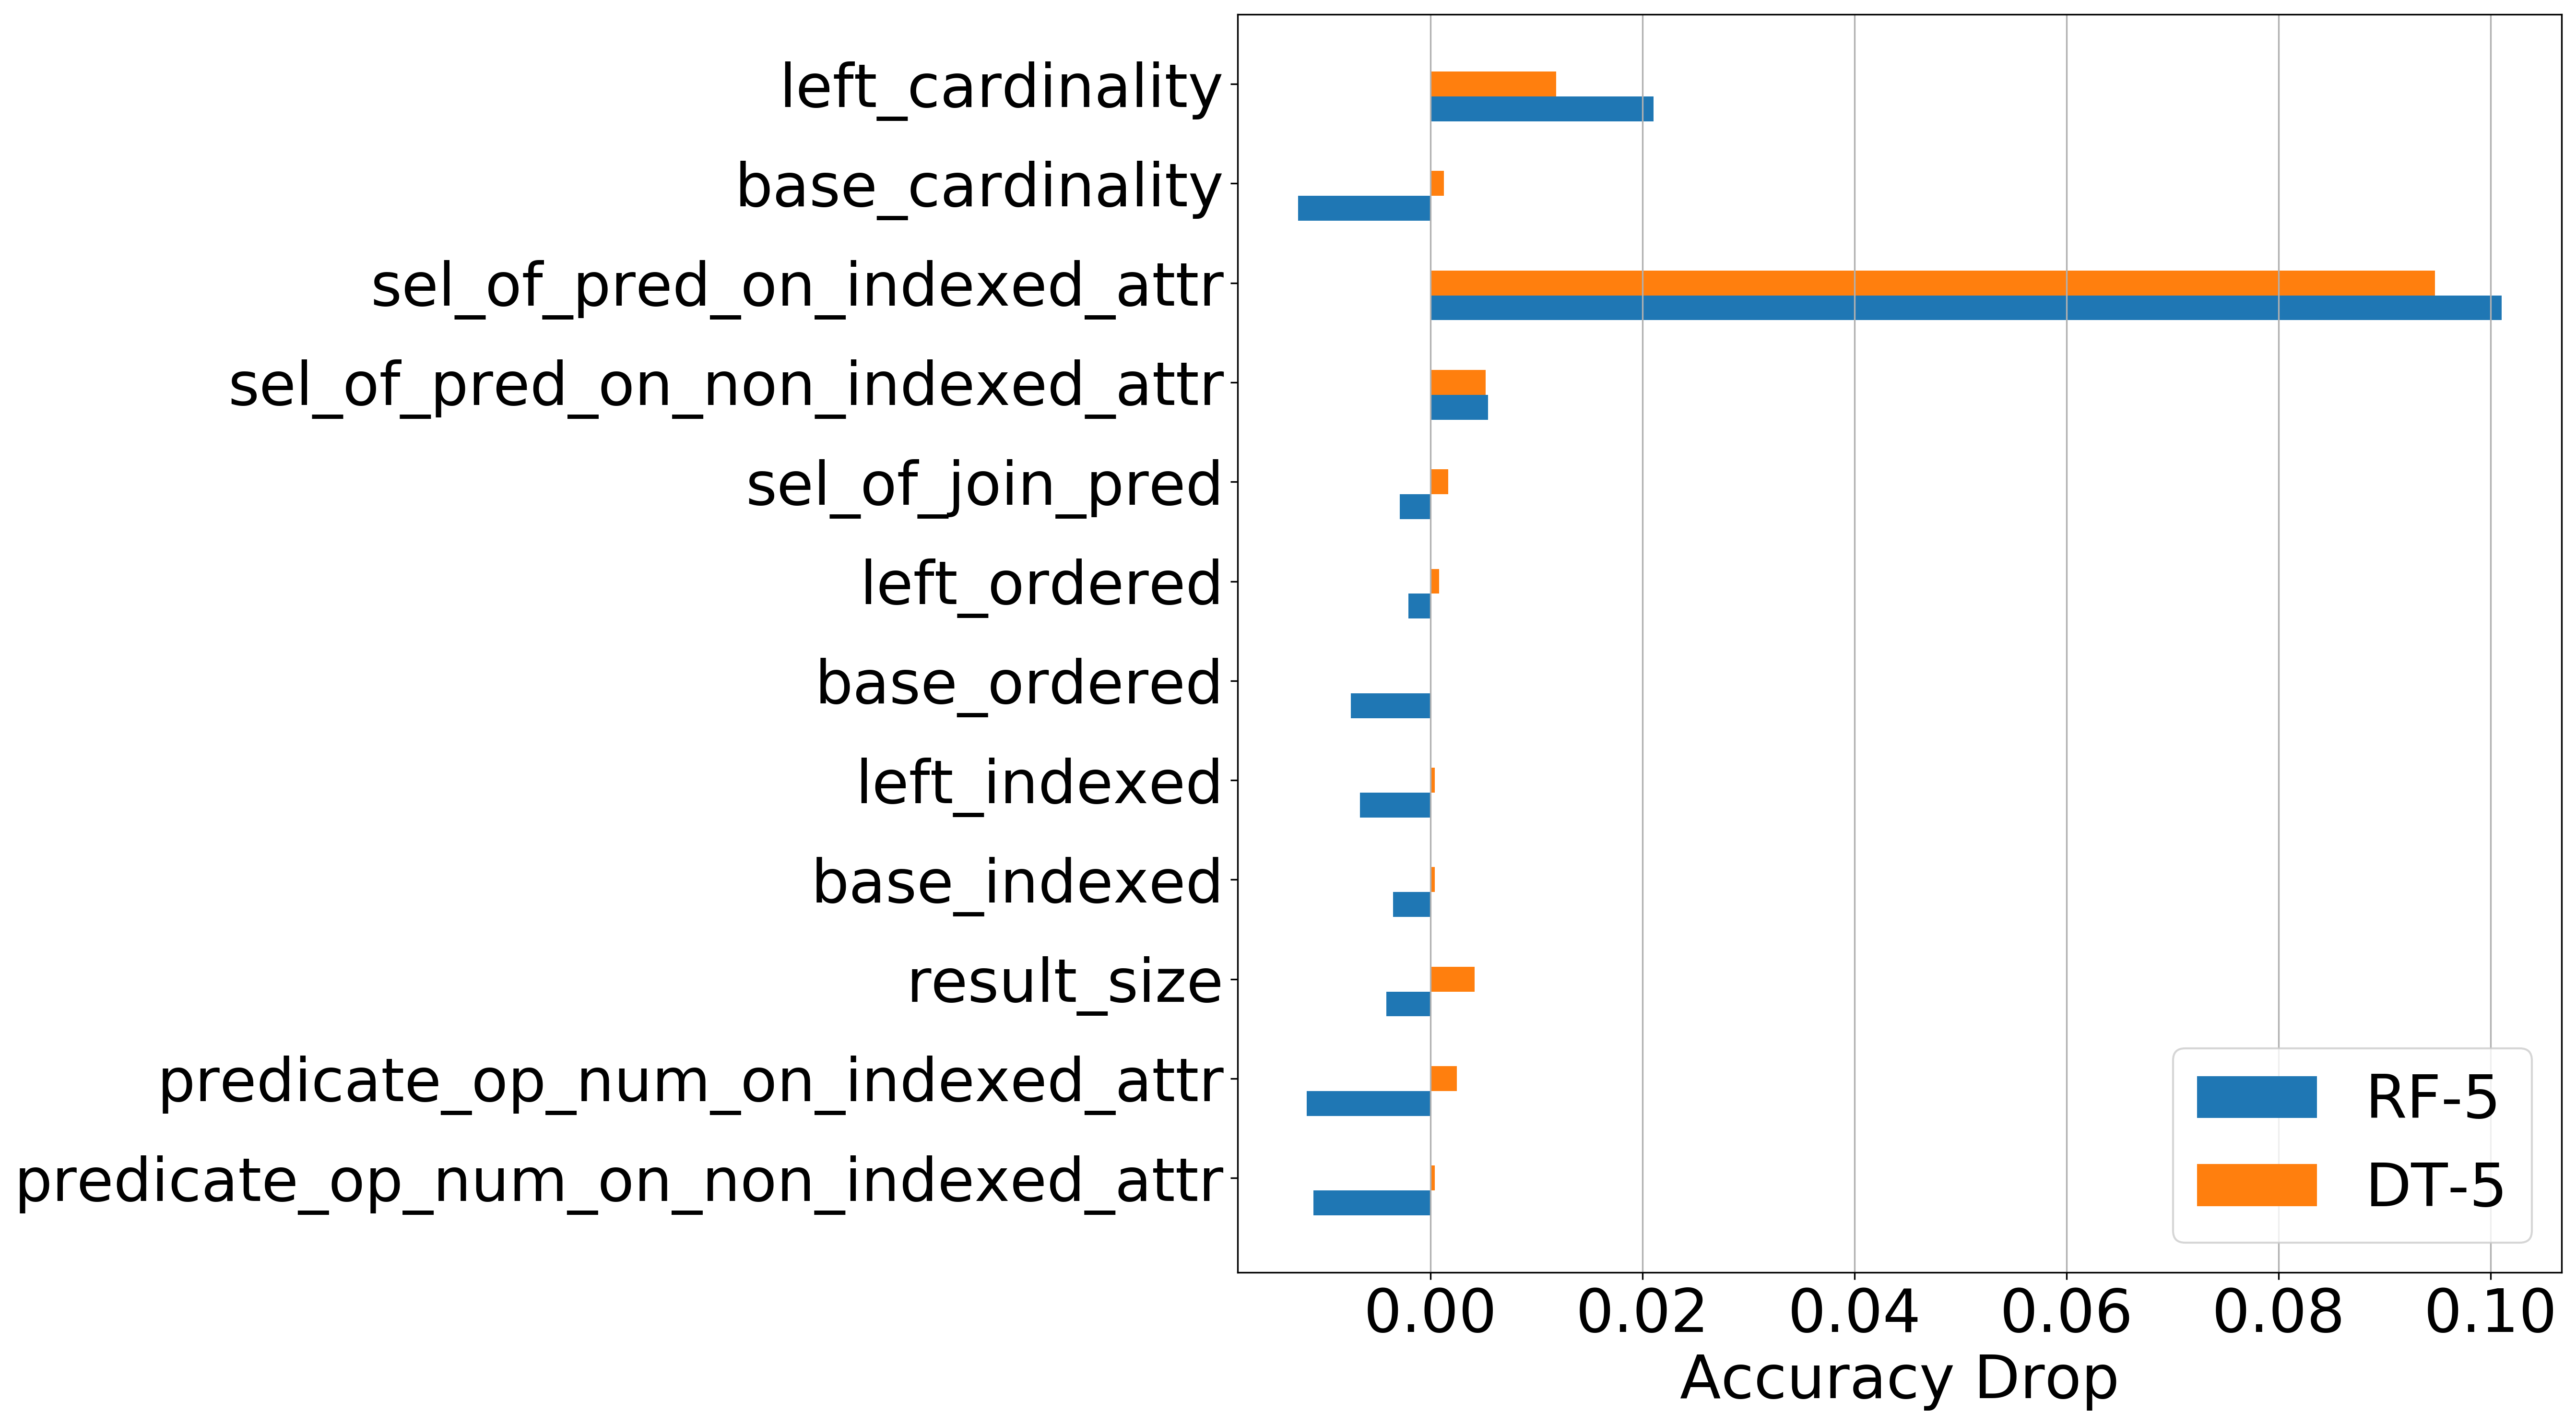

In [17]:
# mlp_drop = np.array(mlp_drop)
dt_drop = np.array(dt_drop)
rf_drop = np.array(rf_drop)

# mssql_imp = overall_imp[1]
# shap_values = shap_values / len(present_idxs)
# importances = np.array([feature_scores[f] for f in features])

# ===========================================
# indices = np.argsort(importances)
# ===========================================
barWidth = 0.5
# indices = [11, 10, 1, 12,  9, 8, 7, 6, 5, 4, 3, 2, 0]
indices = [11,10,9,8,7,6,5,4,3,2,1,0]
# indices = [2,1,0]



import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(18, 10), dpi=300)

# plt.title('Feature Importances')
r1 = [i * 2 for i in range(len(indices))]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.barh(r1, rf_drop[indices], height=barWidth, color='tab:blue', align='center',  label='RF-5')
# plt.barh(r1 , mssql_imp[indices], height=barWidth , color='tab:orange', align='center', label='Microsoft SQL Server')
plt.barh(r2, dt_drop[indices], height=barWidth, color='tab:orange', align='center',  label='DT-5')
# plt.barh(r3, mlp_drop[indices], height=barWidth, color='tab:purple', align='center',  label='MLP')

group_names = ['Group 1: cardinalities', 'Group 2: selectivities', 'Group 3: indices and orders']

plt.yticks([i + 1 * barWidth for i in r1], [all_features[i] for i in indices])
plt.xlabel('Accuracy Drop', fontsize=30)

axes = plt.gca()
axes.tick_params(axis='x', which='major', labelsize=30)
axes.tick_params(axis='y', which='major', labelsize=30)

plt.legend(loc='lower right', prop={'size': 30})

plt.grid(axis='x')
plt.tight_layout()
plt.savefig(f'./figures/exp2-postgres-ablation-feastures.pdf')
plt.show()

## RF

In [15]:
dt_drop = []

for idx, feat_t in enumerate(all_features):
    acc = removed_acc["%d" % idx]['RF(5)']
    drops = []
    for i in range(len(present_idxs)):
        drops.append(acc[i] - postgres_accs[1][i])
    dt_drop.append(-np.average(drops))
    print(f"Avg drop for {feat_t}: {np.average(drops)}")

Avg drop for left_cardinality: -0.004583333333333319
Avg drop for base_cardinality: -0.0012499999999999918
Avg drop for sel_of_pred_on_indexed_attr: -0.000833333333333334
Avg drop for sel_of_pred_on_non_indexed_attr: -0.0002083333333333289
Avg drop for sel_of_pred_on_indexed_attr_and_join_pred: -0.00145833333333333
Avg drop for sel_of_pred_on_non_indexed_attr_and_join_pred: -0.001041666666666663
Avg drop for sel_of_pred_on_indexed_attr_and_non_indexed_attr: -0.002291666666666664
Avg drop for total_sel_on_base_table: 0.0004166666666666763
Avg drop for left_ordered: 0.0012500000000000011
Avg drop for base_ordered: 0.0006250000000000052
Avg drop for left_indexed: -0.0018749999999999785
Avg drop for base_indexed: -0.00041666666666663926
Avg drop for result_size: -0.0008333333333333248
Avg drop for predicate_op_num_on_indexed_attr: -0.0012499999999999827
Avg drop for predicate_op_num_on_non_indexed_attr: 0.0012500000000000011


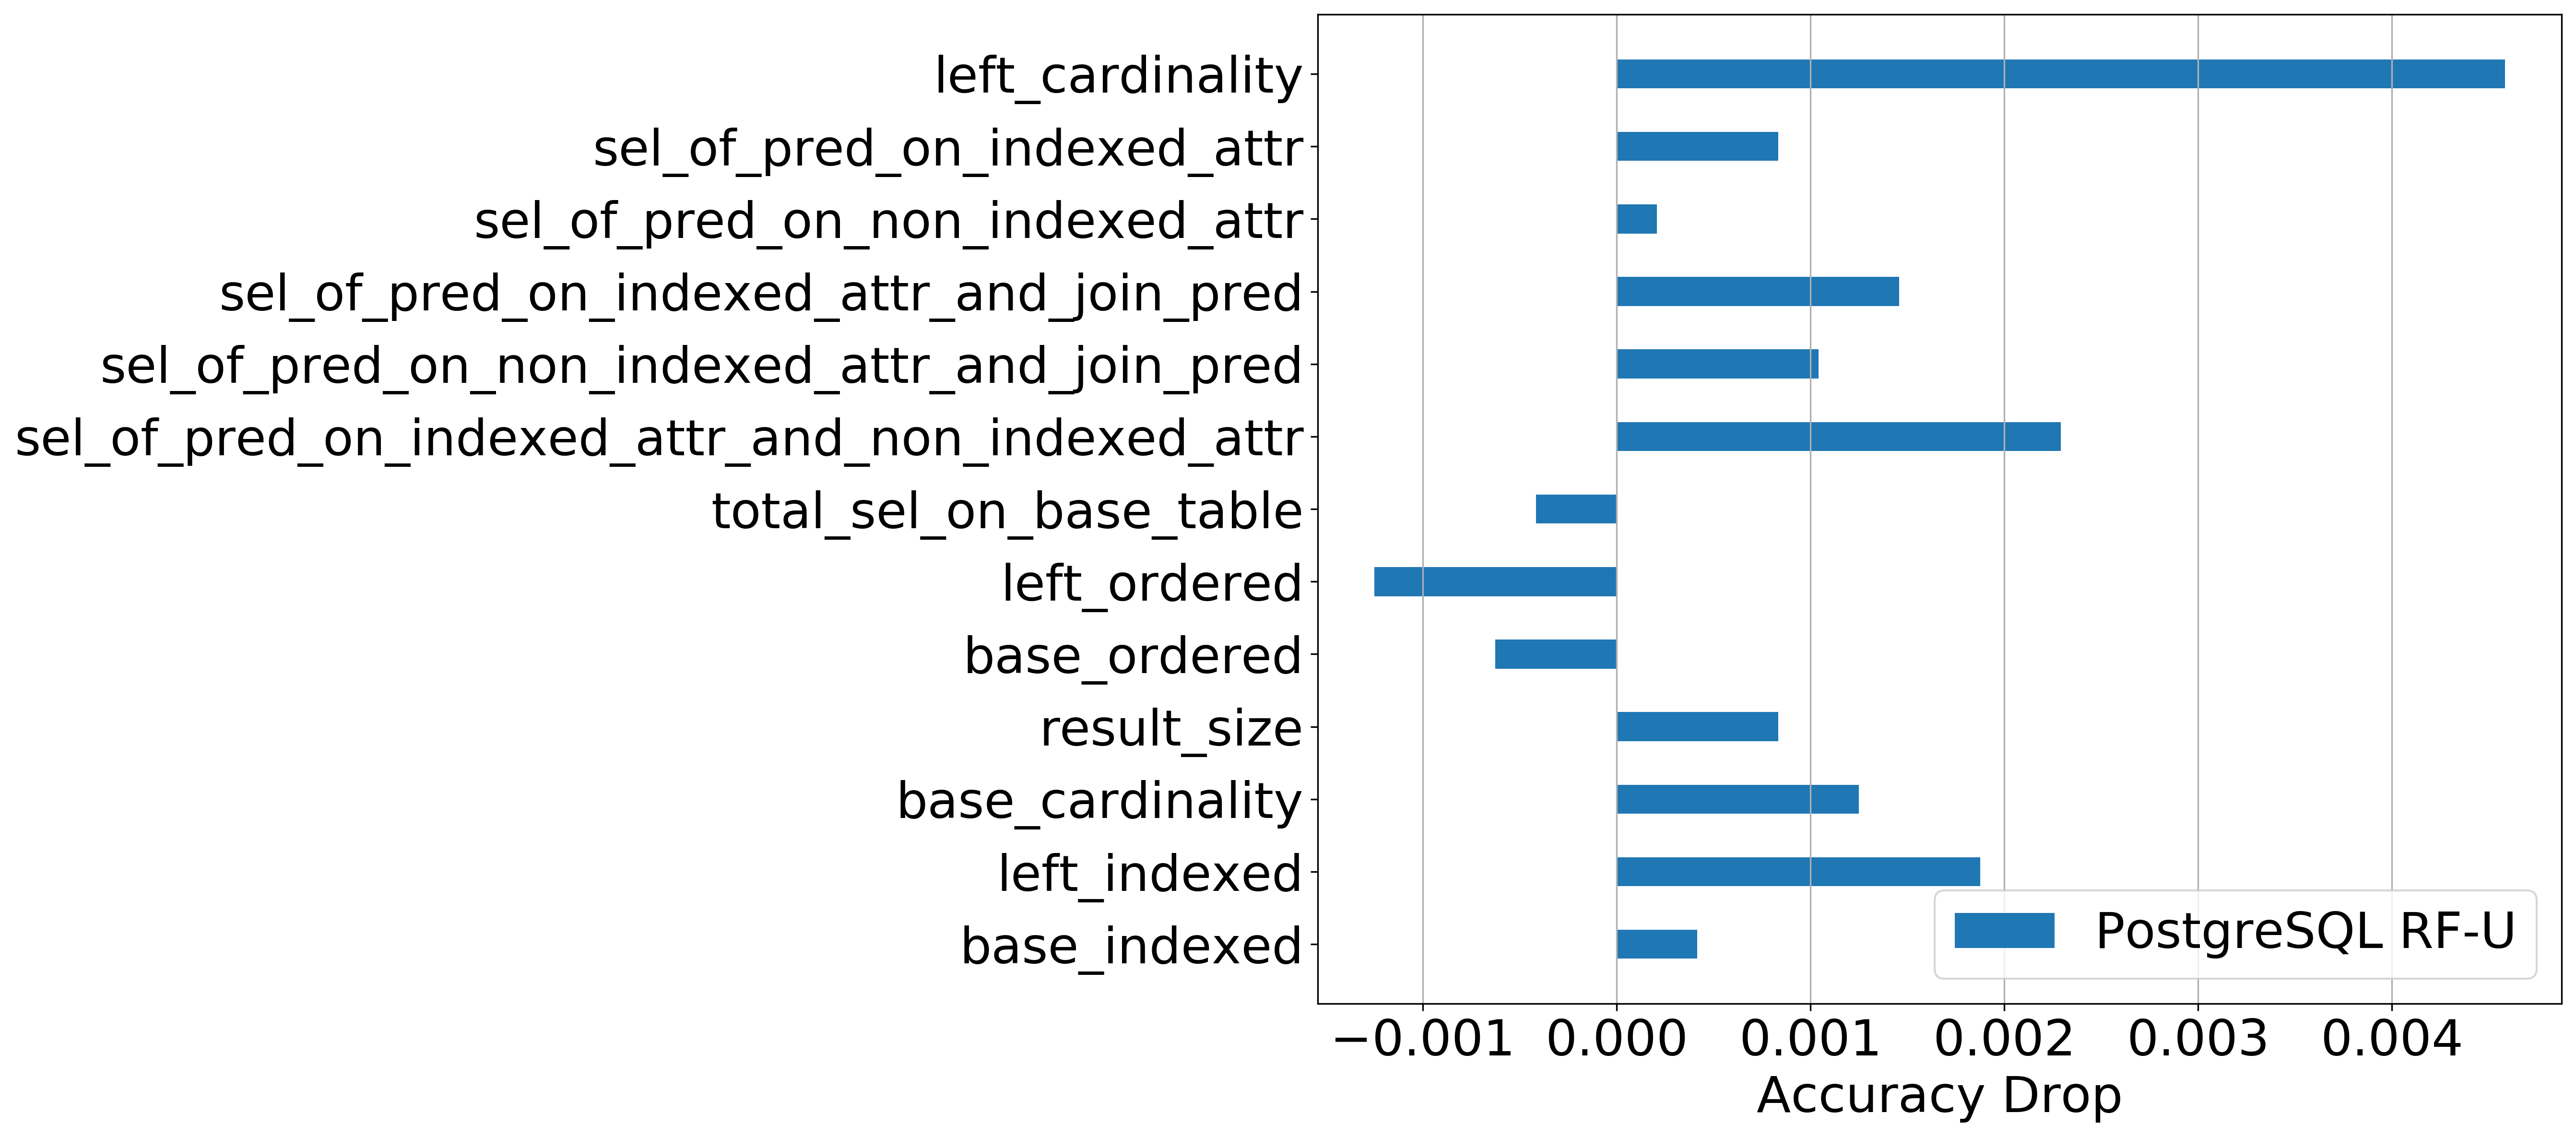

In [16]:
postgre_imp = np.array(dt_drop)
# mssql_imp = overall_imp[1]
# shap_values = shap_values / len(present_idxs)
# importances = np.array([feature_scores[f] for f in features])

# ===========================================
# indices = np.argsort(importances)
# ===========================================
barWidth = 0.4
indices = [11, 10, 1, 12,  9, 8, 7, 6, 5, 4, 3, 2, 0]

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(18, 8), dpi=300)

# plt.title('Feature Importances')
r1 = [i for i in range(13)]
# r2 = [x + barWidth for x in r1]

plt.barh(r1, postgre_imp[indices], height=barWidth, color='tab:blue', align='center',  label='PostgreSQL RF-5')
# plt.barh(r1 , mssql_imp[indices], height=barWidth , color='tab:orange', align='center', label='Microsoft SQL Server')



plt.yticks(range(len(indices)), [dl.all_features[i] for i in indices])
plt.xlabel('Accuracy Drop', fontsize=25)

axes = plt.gca()
axes.tick_params(axis='x', which='major', labelsize=25)
axes.tick_params(axis='y', which='major', labelsize=25)

plt.legend(loc='lower right', prop={'size': 25})

plt.grid(axis='x')
plt.tight_layout()
plt.savefig(f'./figures/exp2-RF-ablation.pdf')
plt.show()